<a href="https://colab.research.google.com/github/zrosen3/Colombian-peso-counterfeit-detection/blob/main/Code/hybrid_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load libraries

In [1]:
#Set up google colab working environment
%cd ~/../content
%rm -rf Colombian-peso-counterfeit-detection
!git clone https://github.com/zrosen3/Colombian-peso-counterfeit-detection.git 
%cd /content/Colombian-peso-counterfeit-detection/Code       

/content
Cloning into 'Colombian-peso-counterfeit-detection'...
remote: Enumerating objects: 42323, done.
remote: Counting objects: 100% (149/149), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 42323 (delta 100), reused 50 (delta 33), pack-reused 42174
Receiving objects: 100% (42323/42323), 884.69 MiB | 18.17 MiB/s, done.
Resolving deltas: 100% (1259/1259), done.
Updating files: 100% (103997/103997), done.
/content/Colombian-peso-counterfeit-detection/Code


In [2]:
import matplotlib.pyplot as plt #For plotting our visualizations
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
import cv2
from PIL import Image
import seaborn as sns
import common_functions as cf
import xgboost as xgb



#Load in data

In [3]:
train_ds, test_ds, validation_ds, class_names = cf.LoadData(path = "../Data/Augmented/", batch_size=12)


Found 24958 files belonging to 13 classes.
Found 8320 files belonging to 13 classes.
Found 8320 files belonging to 13 classes.


## Create ensemble of CNNs


Define CNN model function

In [4]:
def CNNModel(class_names:str,  conv_layers: list = [32], layers: list = [], learning_rate: float = 0.001, dropout: float = 0.5) -> tf.keras.Sequential:
    """
    Simple straight forward CNN model. this is just for simplicity and testing
    atm. I will make it more modular later once I know what we are doing
    Args:
        class_names: list of the classification names
        conv_layers: list of how many filters each convolutional layer should use
        layers: list with the sizes of each hidden layer
        learning_rate: the learning rate for the optimizer
        dropout: the dropout rate for the model
    Returns:
        `tf.keras.Sequential` - a constructed tf model
    """
    tf.keras.backend.clear_session()

    model = tf.keras.Sequential(name = str(i))
    model.add(tf.keras.layers.Rescaling(1./255))
    for filter_count in conv_layers:
        model.add(tf.keras.layers.Conv2D(filter_count, 3, activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Flatten())
    for layer_count in layers:
        model.add(tf.keras.layers.Dense(layer_count, activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=dropout))
    model.add(tf.keras.layers.Dense(len(class_names), activation = 'softmax'))
    model.compile(
      optimizer='adam',
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy'])
    model.fit(
      train_ds,
      validation_data=validation_ds,
      epochs=5)

    return model


Initialize multiple CNNs

In [5]:
#Initialize keras session
tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)
#List parameters for different CNNs
models_config = [
  {'conv_layers': [32], 'layers': []},
  {'conv_layers' : [32, 64], 'layers' : [64, 128]},
  {'conv_layers' : [32, 64], 'layers' : [64, 128, 256]},
]

#Create different models
models = []
for i, config in enumerate(models_config):
    # Create a CNN model with the current configuration
    model = CNNModel(class_names, **config)
    models.append(model)

Epoch 1/5
2080/2080 [==============================] - 64s 25ms/step - loss: 1.8222 - accuracy: 0.7259 - val_loss: 0.3285 - val_accuracy: 0.9142
Epoch 2/5
2080/2080 [==============================] - 52s 25ms/step - loss: 0.1454 - accuracy: 0.9626 - val_loss: 0.2844 - val_accuracy: 0.9328
Epoch 3/5
2080/2080 [==============================] - 52s 25ms/step - loss: 0.0895 - accuracy: 0.9772 - val_loss: 0.1854 - val_accuracy: 0.9529
Epoch 4/5
2080/2080 [==============================] - 52s 25ms/step - loss: 0.0651 - accuracy: 0.9816 - val_loss: 0.1425 - val_accuracy: 0.9575
Epoch 5/5
2080/2080 [==============================] - 52s 25ms/step - loss: 0.0657 - accuracy: 0.9836 - val_loss: 0.1174 - val_accuracy: 0.9621
Epoch 1/5
2080/2080 [==============================] - 69s 32ms/step - loss: 1.3561 - accuracy: 0.4879 - val_loss: 1.2904 - val_accuracy: 0.6412
Epoch 2/5
2080/2080 [==============================] - 66s 32ms/step - loss: 0.3122 - accuracy: 0.8958 - val_loss: 0.2264 - val_ac

Create ensemble model 

In [6]:
input_layer = tf.keras.layers.Input(shape=(480, 640, 3))  
outputs = []
for i,model in enumerate(models):
    model._name = str(i)
    output = model(input_layer)
    outputs.append(output)
averaged_outputs = tf.reduce_mean(outputs, axis = 0)
output_layer = tf.keras.layers.Dense(13, activation='softmax')(averaged_outputs)  
ensemble_model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

Fit ensemble model

In [7]:
#Fit ensemble model 
ensemble_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

history = ensemble_model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=5)

Epoch 1/5
2080/2080 [==============================] - 118s 54ms/step - loss: 1.9695 - accuracy: 0.5096 - val_loss: 1.6068 - val_accuracy: 0.5331
Epoch 2/5
2080/2080 [==============================] - 113s 54ms/step - loss: 1.2888 - accuracy: 0.5477 - val_loss: 1.0946 - val_accuracy: 0.5375
Epoch 3/5
2080/2080 [==============================] - 112s 54ms/step - loss: 1.4615 - accuracy: 0.5004 - val_loss: 1.4126 - val_accuracy: 0.5242
Epoch 4/5
2080/2080 [==============================] - 113s 54ms/step - loss: 1.2789 - accuracy: 0.5318 - val_loss: 1.2011 - val_accuracy: 0.5274
Epoch 5/5
2080/2080 [==============================] - 113s 54ms/step - loss: 1.1066 - accuracy: 0.5329 - val_loss: 1.0740 - val_accuracy: 0.5260


## Inspect model performance

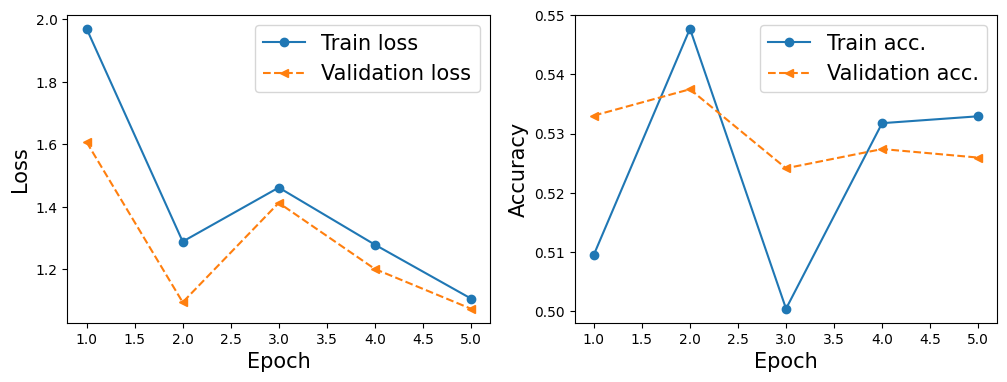

694/694 - 16s - loss: 1.0849 - accuracy: 0.5238 - 16s/epoch - 23ms/step
Test loss: 1.084900140762329 | Test accuracy: 0.5237980484962463


(0.5329353213310242, 0.5259615182876587, 0.5237980484962463)

In [8]:
cf.EvaluateModel(ensemble_model, test_ds, history)


Macro averaged precision score: 0.5237980769230769
Macro averaged recall score: 0.4829363767467243
Macro averaged F1 score: 0.40774488808666054


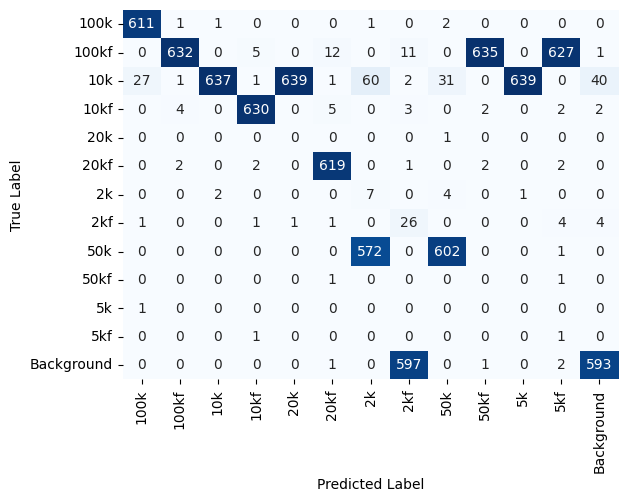

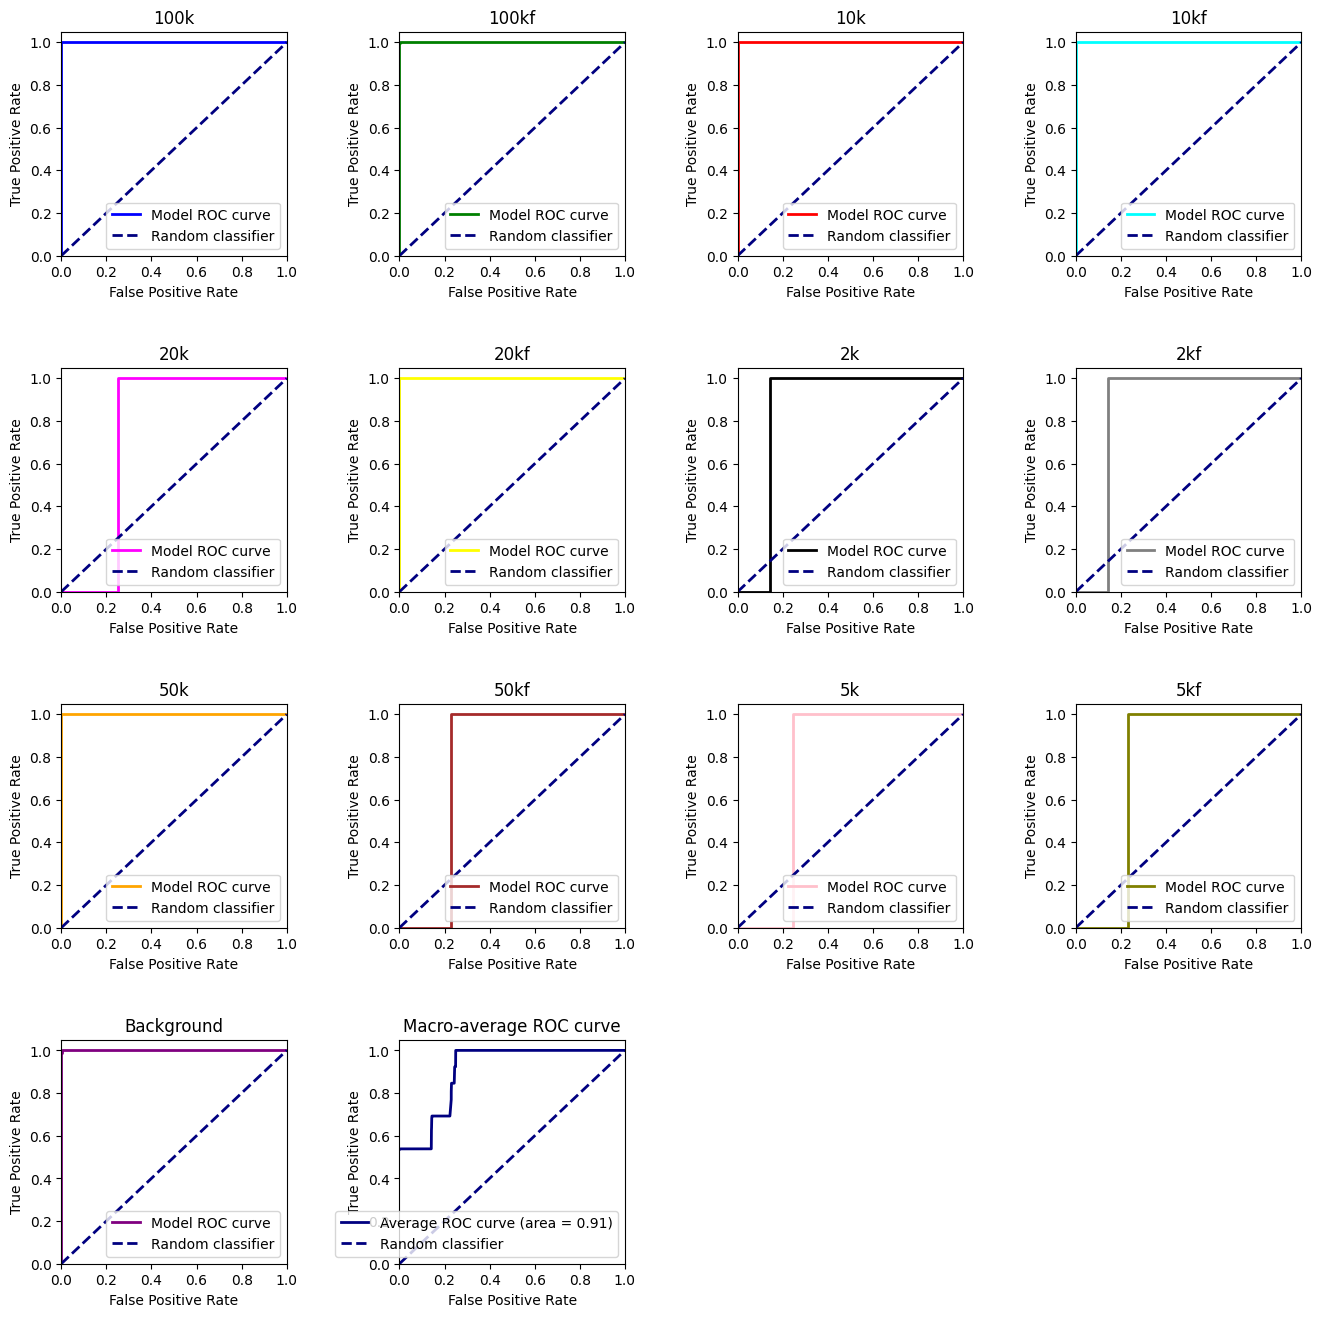

In [9]:
cf.precision_recall_metrics(ensemble_model, test_ds, class_names)